<a href="https://colab.research.google.com/github/SunshineGreeny/Dive-into-deep-learning-Pytorch/blob/main/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Attention and Positional Encoding



In [11]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt

Tools

In [15]:
def check_shape(tensor, expected_shape):
    assert tensor.shape == expected_shape, \
        f"Expected shape: {expected_shape}, but got: {tensor.shape}"
    return tensor


def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(3.5, 2.5),
                  sharex=True,sharey=True,squeeze=False):
    num_rows,num_cols=matrices.shape[0],matrices.shape[1]

    # 创建子图网络
    fig,axes=plt.subplots(num_rows,num_cols,figsize=figsize,
                          sharex=True,sharey=True,squeeze=False)
    # 遍历所有矩阵并绘制热力图
    for i in range(num_rows):
        for j in range(num_cols):
            ax=axes[i,j]
            # 将张量转换为numpy数组并分离计算图
            matrix=matrices[i,j].detach().numpy()

            # 使用热力图显示矩阵
            pcm=ax.imshow(matrix,cmap='Reds')

            # 设置坐标轴标签
            if i==num_rows-1:#最后一行显示x轴标签
                ax.set_xlabel(xlabel)
            if j==0:#第一列显示y轴标签
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

            # 隐藏刻度线
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')

    # Add a colorbar
    fig.colorbar(pcm, ax=axes.ravel().tolist())
    plt.show()


def masked_softmax(X,valid_lens):
  def _sequence_mask(X,valid_len,value=0):
    maxlen=X.size(1)
    mask=torch.arange((maxlen),dtype=torch.float32,
                      device=X.device)[None,:]<valid_len[:,None]
    X[~mask]=value
    return X

  if valid_lens is None:
    return nn.functional.softmax(X,dim=-1)
  else:
    shape=X.shape

    if valid_lens.dim()==1:
      valid_lens=torch.repeat_interleave(valid_lens,shape[1])
    else:
      valid_lens=valid_lens.reshape(-1)

    X=_sequence_mask(X.reshape(-1,shape[-1]),valid_lens,value=-1e6)
    return nn.functional.softmax(X.reshape(shape),dim=-1)


class DotProductAttention(nn.Module):
  def __init__(self,dropout):
    super().__init__()
    self.dropout=nn.Dropout(dropout)

  def forward(self,queries,keys,values,valid_lens=None):
    d=queries.shape[-1]
    scores=torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
    self.attention_weights=masked_softmax(scores,valid_lens) # Corrected here
    return torch.bmm(self.dropout(self.attention_weights),values)


class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self,num_hiddens,num_heads,dropout,bias=False,**kwargs):
      super(MultiHeadAttention,self).__init__(**kwargs)
      self.num_heads=num_heads
      self.num_hiddens=num_hiddens
      # 线性映射qkv和输出
      self.W_q=nn.Linear(num_hiddens,num_hiddens,bias=bias)
      self.W_k=nn.Linear(num_hiddens,num_hiddens,bias=bias)
      self.W_v=nn.Linear(num_hiddens,num_hiddens,bias=bias)
      self.W_o=nn.Linear(num_hiddens,num_hiddens,bias=bias)
      self.dropout=nn.Dropout(dropout)
      self.attention=DotProductAttention(dropout)

    def transpose_qkv(self,X):
      # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
      X=X.reshape(X.shape[0],X.shape[1],self.num_heads,-1)
      X=X.permute(0,2,1,3)
      # 输出
      return X.reshape(-1,X.shape[2],X.shape[3])#合并batch和head

    def transpose_output(self,X):
      # Undo the transpose and combine the heads
      X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
      X = X.permute(0, 2, 1, 3)
      # Reshape to original batch size and sequence length, with num_hiddens
      return X.reshape(X.shape[0], X.shape[1], -1)

    def forward(self,queries,keys,values,valid_lens):
      # queries，keys，values的形状:
      Q=self.transpose_qkv(self.W_q(queries))
      K=self.transpose_qkv(self.W_k(keys))
      V=self.transpose_qkv(self.W_v(values))
      # (batch_size，查询或者“键－值”对的个数，num_hiddens)

      if valid_lens is not None:
        # 在轴0，将第一项（标量或者矢量)复制num_heads次，然后如此复制第二项，
        # 然后诸如此类。
        valid_lens=torch.repeat_interleave(
            valid_lens,repeats=self.num_heads,dim=0)

      output=self.attention(Q,K,V,valid_lens)
      output=self.transpose_output(output)
      return self.W_o(output)

Self-Attention

In [16]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
check_shape(attention(X, X, X, valid_lens),
                (batch_size, num_queries, num_hiddens))

tensor([[[ 1.9458e-01, -3.1267e-01, -4.3155e-01, -7.6889e-01,  2.2897e-01,
          -6.2889e-01,  3.5071e-01,  8.1099e-01,  4.8938e-01, -1.2107e-01,
           7.8875e-01, -2.5901e-01,  1.2733e-01,  4.1988e-01,  2.7949e-01,
          -2.9085e-01,  4.8428e-01,  3.3161e-01,  4.8349e-01, -1.9806e-01,
          -5.8118e-01, -6.0638e-01,  8.4236e-01, -8.5931e-01, -2.9654e-01,
          -2.7691e-01,  6.1304e-01, -3.1151e-01,  2.0878e-01,  4.8760e-01,
          -9.8865e-01, -1.5838e-01, -4.7706e-01,  7.7707e-01,  2.6968e-01,
          -9.8430e-01,  3.4018e-01, -4.4347e-01,  2.4316e-01, -2.3776e-01,
          -2.0503e-01, -8.0744e-01,  2.6629e-01,  5.7395e-01,  2.7591e-01,
          -3.1909e-01,  7.9512e-01, -9.5609e-01,  6.8895e-02, -6.0477e-01,
          -1.3815e-01,  1.0432e+00, -4.8018e-02,  7.9961e-02, -7.6823e-01,
          -7.8518e-01,  1.9307e-01, -9.6936e-01, -4.3333e-01,  5.3075e-01,
          -7.7685e-01,  5.9349e-01, -6.9652e-01,  6.0297e-01,  8.5366e-02,
           2.8005e-01,  4

Positional Encoding

In [17]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

Plot data points

In [21]:
def plot(X, Y, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""

    if axes is None:
        _, axes = plt.subplots(figsize=figsize)
    axes.plot(X, Y.T, fmts)

    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    plt.show()

Rows correspond to positions within a sequence
and columns represent different positional encoding dimensions

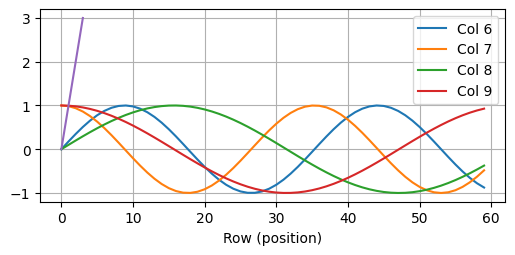

In [23]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

The binary representations

In [19]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


The positional encoding decreases
frequencies along the encoding dimension

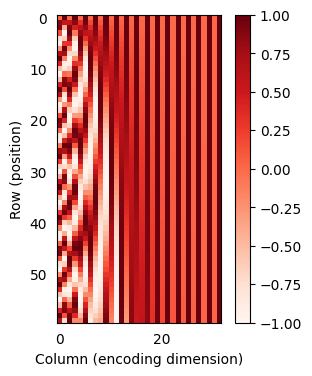

In [24]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4))